# Signals
- Generate a buy, sell signal depending on the following conditions:
    - Cross-over of 5-day and 20-day moving averages.
    - Market sentiment is positive.
    - ARIMA model predicts an increase in the stock price.
    - RSI (relative strength index)

- Consider 30 minute intervals for stock price data

## Cross-over Strategy

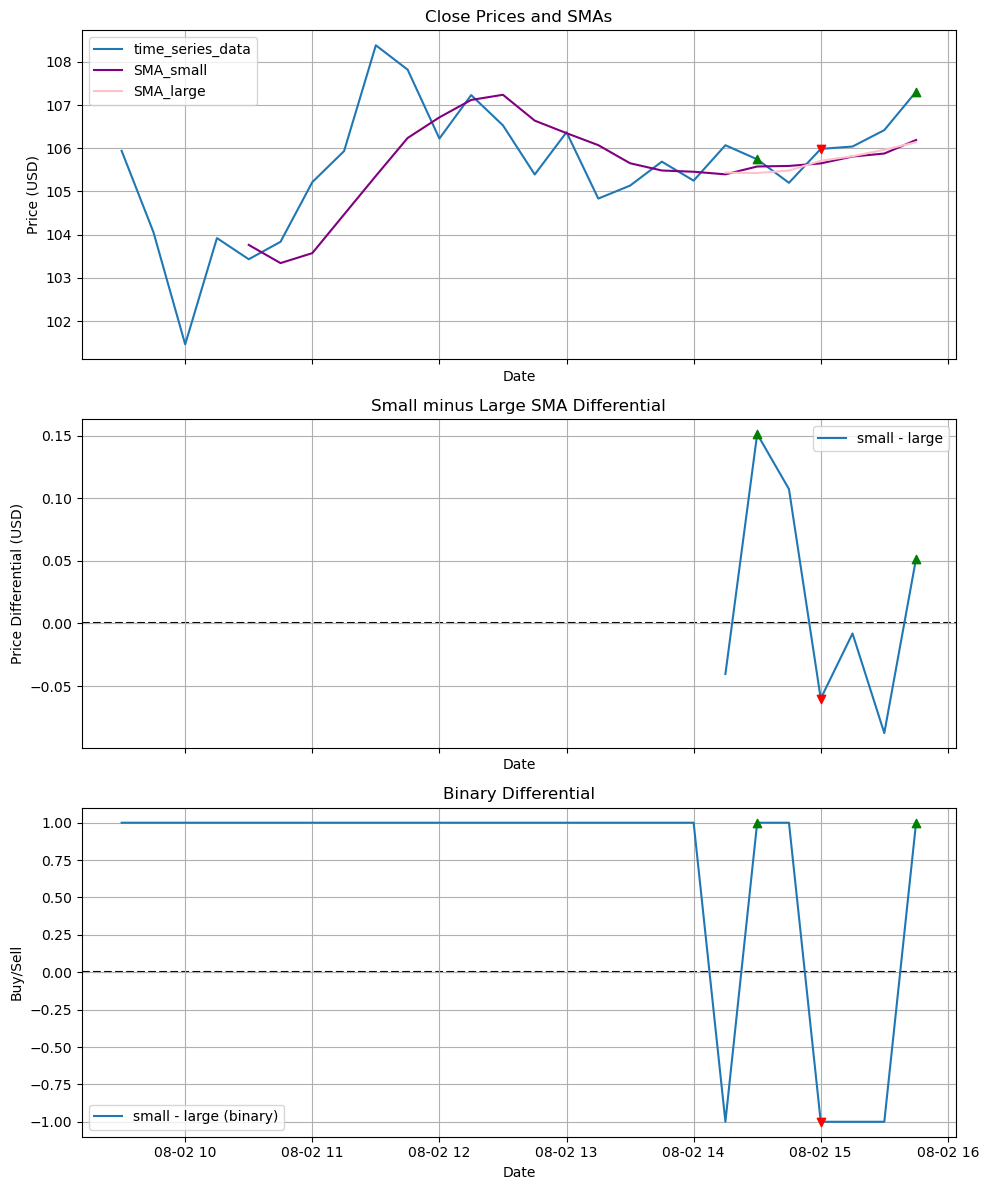

{'buy': [Timestamp('2024-08-02 14:30:00-0400', tz='America/New_York'),
  Timestamp('2024-08-02 15:45:00-0400', tz='America/New_York')],
 'sell': [Timestamp('2024-08-02 15:00:00-0400', tz='America/New_York')]}

In [5]:
import matplotlib.pyplot as plt 
import yfinance as yf
import pandas as pd


def my_cross_over_strategy(ticker, start, end, interval, window_small, window_large):
    """
    We want to output a signal buy or sell, depending on when we have a cross over between the large and small moving averages
    e.g. 10, 14, (small)
        11, 12 (large) -> output a buy signal, since the small oving average cross over the large
    """
    time_series = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
    time_series['SMA_small'] = time_series['Close'].rolling(window=window_small).mean()
    time_series['SMA_large'] = time_series['Close'].rolling(window=window_large).mean()
    
    ## let's compare small with large:
    time_series['Small > Large'] = time_series['SMA_small'] > time_series['SMA_large']
    
    # when False -> True
    # Positive cross over, so now small is greater than large, buy signal
    
    signals = {
        'buy': [],
        'sell': []
    }
    
    boolean_column = time_series['Small > Large']
    previous = boolean_column.values[0]
    for index in boolean_column.index:
        current = boolean_column[index]
        if previous == current:
            # don't send signal nothing has crossed over
            previous = current
            continue
        else:
            # we send a signal, because something has crossed over
            # but we need to figure out if it's a positive or negative cross over
            if current == True:
                previous = current
                # if current was true, then the previous must have been false
                # print(f'Buy signal @ {index}')
                signals['buy'].append(index)
            else:
                previous = current 
                # if current was false, then the previous must have been true 
                # print(f'Sell signal @ {index}')     
                signals['sell'].append(index)
    time_series['small - large'] = time_series['SMA_small'] - time_series['SMA_large']
    time_series['binary'] = time_series['small - large'].apply(lambda x: -1 if x < 0 else 1)
    
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    ax[0].plot(time_series.index, time_series['Close'].values, label='time_series_data')
    ax[0].plot(time_series.index, time_series['SMA_small'].values, color='purple', label='SMA_small')
    ax[0].plot(time_series.index, time_series['SMA_large'].values, color='pink', label='SMA_large')
    ax[0].set_ylabel('Price (USD)')
    ax[0].set_title('Close Prices and SMAs')
    
    ax[1].plot(time_series.index, time_series['small - large'], label='small - large')
    ax[1].axhline(y=0, color='k', linestyle='--', zorder=-4)
    ax[1].set_ylabel('Price Differential (USD)')
    ax[1].set_title('Small minus Large SMA Differential')
    
    
    ax[2].plot(time_series.index, time_series['binary'], label='small - large (binary)')
    ax[2].axhline(y=0, color='k', linestyle='--', zorder=-4)
    ax[2].set_ylabel('Buy/Sell')
    ax[2].set_title('Binary Differential')
    
    
    ## I want to show on the graph, the buy and sell signals
    for i, series in enumerate(['Close', 'small - large', 'binary']):
        for key in signals.keys():
            for date in signals[key]:
                # plt.axvline(date, color = ('g' if key == 'buy' else 'r'))
                ax[i].scatter(date, time_series.loc[date, series] ,color = ('g' if key == 'buy' else 'r'), zorder = 10, marker=('^' if key == 'buy' else 'v'))
                ax[i].grid(zorder=-5)
                ax[i].legend(loc='best')
                ax[i].set_xlabel('Date')
    plt.tight_layout()
    plt.show()
    return signals
        
my_cross_over_strategy('NVDA', '2024-08-02', '2024-08-05', '15m',5, 20)

## Rate of Change (ROC)

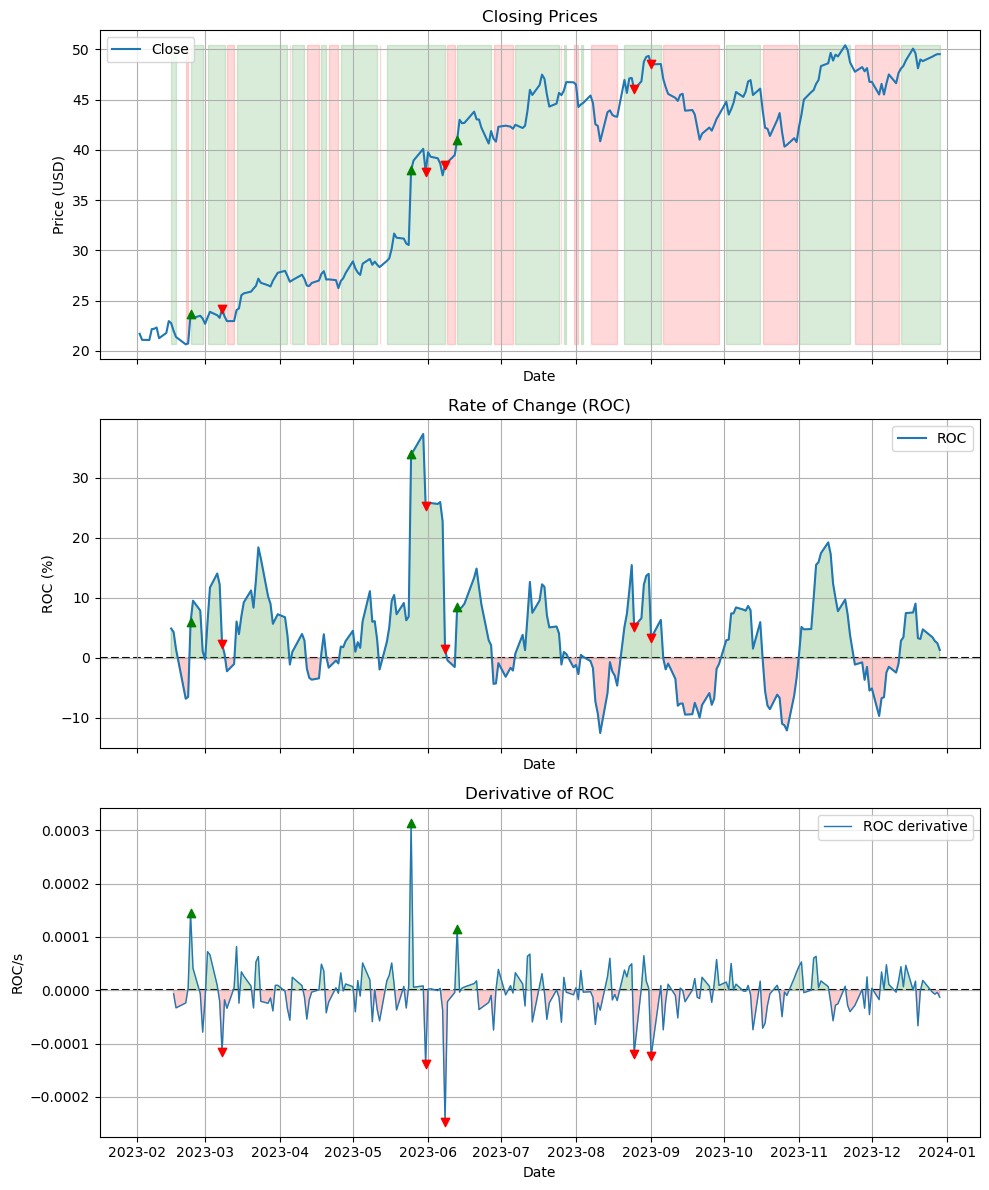

{'buy': [Timestamp('2023-02-23 00:00:00-0500', tz='America/New_York'),
  Timestamp('2023-05-25 00:00:00-0400', tz='America/New_York'),
  Timestamp('2023-06-13 00:00:00-0400', tz='America/New_York')],
 'sell': [Timestamp('2023-03-08 00:00:00-0500', tz='America/New_York'),
  Timestamp('2023-05-31 00:00:00-0400', tz='America/New_York'),
  Timestamp('2023-06-08 00:00:00-0400', tz='America/New_York'),
  Timestamp('2023-08-25 00:00:00-0400', tz='America/New_York'),
  Timestamp('2023-09-01 00:00:00-0400', tz='America/New_York')]}

In [227]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


def my_roc(ticker, start, end, interval, shift = 9):
    time_series = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
    time_series['ROC'] = (time_series['Close'] / time_series['Close'].shift(shift) - 1) * 100
    time_series['ROC_derivative'] = (time_series['ROC'] - time_series['ROC'].shift(1)) / pd.to_timedelta(time_series.index.to_series().diff(1)).dt.total_seconds()
    signals = {
        'buy': [],
        'sell': []
    }
    
    signals['buy'] = list(time_series[time_series['ROC_derivative'] > 0.0001].index)
    signals['sell'] = list(time_series[time_series['ROC_derivative'] < -0.0001].index)
    
    # print(signals)
    fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    ax[0].plot(time_series.index, time_series['Close'], label='Close')
    ax[0].set_title('Closing Prices')
    ax[0].set_ylabel('Price (USD)')
    ax[0].legend()
    ax[0].grid()
    ax[0].fill_between(time_series.index, time_series['Close'].min(), time_series['Close'].max(), where=(time_series['ROC'] < 0), color='red', alpha=0.15, interpolate=False, zorder=-5)
    ax[0].fill_between(time_series.index, time_series['Close'].min(), time_series['Close'].max(), where=(time_series['ROC'] >= 0), color='green', alpha=0.15, interpolate=False, zorder=-5)

    
    ax[1].plot(time_series.index, time_series['ROC'], label='ROC')
    ax[1].set_title('Rate of Change (ROC)')
    ax[1].set_ylabel('ROC (%)')
    ax[1].legend()
    ax[1].grid()
    ax[1].fill_between(time_series.index, 0, time_series['ROC'], where = (time_series['ROC'] >= 0), color='g', alpha=0.2, interpolate=True)
    ax[1].fill_between(time_series.index, 0, time_series['ROC'], where = (time_series['ROC']  < 0), color='r', alpha=0.2, interpolate=True)
    ax[1].axhline(y=0, color='k', linestyle='--', zorder=-4)
    
    ax[2].plot(time_series.index, time_series['ROC_derivative'], label='ROC derivative', linewidth=1)
    ax[2].set_title('Derivative of ROC')
    ax[2].set_ylabel('ROC/s')
    ax[2].legend()
    ax[2].grid()
    ax[2].axhline(y=0, color='k', linestyle='--', zorder=-4)
    ax[2].fill_between(time_series.index, 0, time_series['ROC_derivative'], where = (time_series['ROC_derivative'] >= 0), color='g', alpha=0.2, interpolate=True)
    ax[2].fill_between(time_series.index, 0, time_series['ROC_derivative'], where = (time_series['ROC_derivative']  < 0), color='r', alpha=0.2, interpolate=True)
    
    for i, series in enumerate(['Close', 'ROC', 'ROC_derivative']):
        for key in signals.keys():
            for date in signals[key]:
                ax[i].scatter(date, time_series.loc[date, series], color = ('g' if key == 'buy' else 'r'), zorder = 10, marker=('^' if key == 'buy' else 'v'))
                ax[i].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
    return signals


my_roc('NVDA', '2023-02-02', '2024-01-01', '1d')

## Relative Strength Index (RSI)

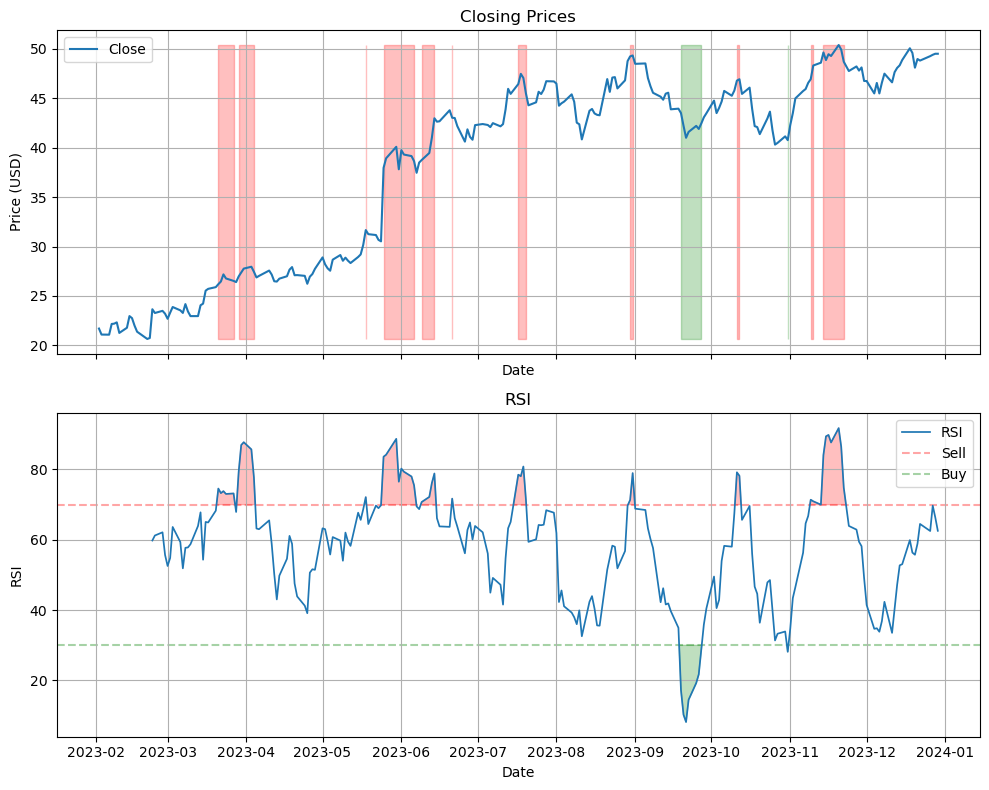

{'buy': DatetimeIndex(['2023-09-19 00:00:00-04:00', '2023-09-20 00:00:00-04:00',
                '2023-09-21 00:00:00-04:00', '2023-09-22 00:00:00-04:00',
                '2023-09-25 00:00:00-04:00', '2023-09-26 00:00:00-04:00',
                '2023-09-27 00:00:00-04:00', '2023-10-31 00:00:00-04:00'],
               dtype='datetime64[ns, America/New_York]', name='Date', freq=None),
 'sell': DatetimeIndex(['2023-03-21 00:00:00-04:00', '2023-03-22 00:00:00-04:00',
                '2023-03-23 00:00:00-04:00', '2023-03-24 00:00:00-04:00',
                '2023-03-27 00:00:00-04:00', '2023-03-29 00:00:00-04:00',
                '2023-03-30 00:00:00-04:00', '2023-03-31 00:00:00-04:00',
                '2023-04-03 00:00:00-04:00', '2023-04-04 00:00:00-04:00',
                '2023-05-18 00:00:00-04:00', '2023-05-25 00:00:00-04:00',
                '2023-05-26 00:00:00-04:00', '2023-05-30 00:00:00-04:00',
                '2023-05-31 00:00:00-04:00', '2023-06-01 00:00:00-04:00',
              

In [221]:
def my_rsi(ticker, start, end, interval, lookback, min, max):

    time_series = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
    difference = time_series['Close'].diff(1)
    price_up = difference.copy()
    price_down = difference.copy()

    price_up[price_up < 0] = 0
    price_down[price_down  >  0] = 0
    
    mean_up = price_up.rolling(window=lookback).mean().dropna()
    mean_down = price_down.abs().rolling(window=lookback).mean().dropna()
    
    RSI = 100 - (100/ (1+ ( mean_up / mean_down )))
    
    signals = {
        'buy': [],
        'sell': []
    }
    
    signals['buy'] = RSI[RSI < min].index
    signals['sell'] = RSI[RSI > max].index
    
    fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

    ax[0].plot(time_series.index, time_series['Close'], label='Close')
    ax[0].set_title('Closing Prices')
    ax[0].fill_between(RSI.index, time_series['Close'].min(), time_series['Close'].max(), where = (RSI > max), alpha=0.25, color ='r', interpolate=False)
    ax[0].fill_between(RSI.index, time_series['Close'].min(), time_series['Close'].max(), where = (RSI < min), alpha=0.25, color ='g', interpolate=False)
    ax[0].set_ylabel('Price (USD)')
    
    ax[1].plot(RSI.index, RSI, label='RSI', linewidth=1.25)
    ax[1].set_title('RSI')
    ax[1].set_ylabel('RSI')
    ax[1].fill_between(RSI.index, RSI, max, where = (RSI > max), alpha=0.25, color ='r', interpolate=True)
    ax[1].fill_between(RSI.index, RSI, min, where = (RSI < min), alpha=0.25, color ='g', interpolate=True)
    ax[1].axhline(y=max, color='r', zorder=-3, alpha=0.35, linestyle='--', label='Sell')
    ax[1].axhline(y=min, color='g', zorder=-3, alpha=0.35, linestyle='--', label='Buy')
    
    
    for i, series in enumerate(['Close', 'RSI']):
        ax[i].set_xlabel('Date')
        ax[i].grid()
        ax[i].legend()
    plt.tight_layout()
    plt.show()
    return signals
        

my_rsi('NVDA', '2023-02-02', '2024-01-01', '1d', 14, 30, 70)

## Money Flow Index (MFI)

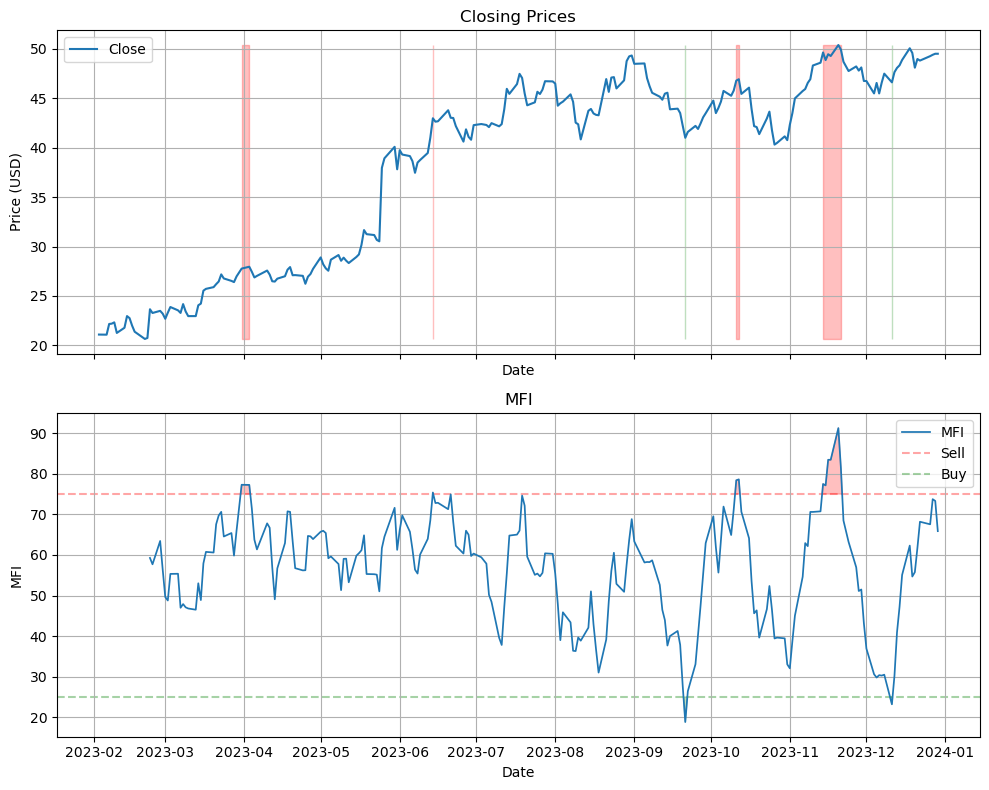

{'buy': DatetimeIndex(['2023-09-21 00:00:00-04:00', '2023-12-11 00:00:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Date', freq=None),
 'sell': DatetimeIndex(['2023-03-31 00:00:00-04:00', '2023-04-03 00:00:00-04:00',
                '2023-06-14 00:00:00-04:00', '2023-10-11 00:00:00-04:00',
                '2023-10-12 00:00:00-04:00', '2023-11-14 00:00:00-05:00',
                '2023-11-15 00:00:00-05:00', '2023-11-16 00:00:00-05:00',
                '2023-11-17 00:00:00-05:00', '2023-11-20 00:00:00-05:00',
                '2023-11-21 00:00:00-05:00'],
               dtype='datetime64[ns, America/New_York]', name='Date', freq=None)}

In [222]:

def my_mfi(ticker, start, end, interval, period = 14, min = 20, max = 80):
    time_series = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
    time_series['typical_price'] = (time_series['Close'] + time_series['High'] + time_series['Low']) / 3
    time_series['money_flow'] = time_series['typical_price'] * time_series['Volume']

    time_series['flows'] = time_series['typical_price'].diff(1)
    time_series.dropna(inplace=True)

    time_series['flow_positive'] = time_series['money_flow'].where(time_series['flows'] > 0, 0)
    time_series['flow_negative'] = time_series['money_flow'].where(time_series['flows'] < 0, 0)
    # display(time_series)
    
    plus_mf = time_series['flow_positive'].rolling(window = period).sum()
    minus_mf = time_series['flow_negative'].rolling(window = period).sum()
    
    MFI = 100 * (plus_mf / (plus_mf + minus_mf))

    signals = {
        'buy': [],
        'sell': []
    }
    signals['buy'] = MFI[MFI < min].index
    signals['sell'] = MFI[MFI > max].index
    fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
    
    ax[0].plot(time_series.index, time_series['Close'], label='Close')
    ax[0].set_title('Closing Prices')
    ax[0].fill_between(MFI.index, time_series['Close'].min(), time_series['Close'].max(), where = (MFI > max), alpha=0.25, color ='r', interpolate=False)
    ax[0].fill_between(MFI.index, time_series['Close'].min(), time_series['Close'].max(), where = (MFI < min), alpha=0.25, color ='g', interpolate=False)
    ax[0].set_ylabel('Price (USD)')
    
    ax[1].plot(MFI.index, MFI, label='MFI', linewidth=1.25)
    ax[1].set_title('MFI')
    ax[1].set_ylabel('MFI')
    ax[1].fill_between(MFI.index, MFI, max, where = (MFI > max), alpha=0.25, color ='r', interpolate=True)
    ax[1].fill_between(MFI.index, MFI, min, where = (MFI < min), alpha=0.25, color ='g', interpolate=True)
    ax[1].axhline(y=max, color='r', zorder=-3, alpha=0.35, linestyle='--', label='Sell')
    ax[1].axhline(y=min, color='g', zorder=-3, alpha=0.35, linestyle='--', label='Buy')
    
    for i, series in enumerate(['Close', 'MFI']):
        ax[i].grid()

        ax[i].set_xlabel('Date')
        ax[i].legend()
    plt.tight_layout()
    plt.show()
    return signals

my_mfi('NVDA', '2023-02-02', '2024-01-01', '1d',14, 25, 75)

## Stochastic Momentum Index (SMI)

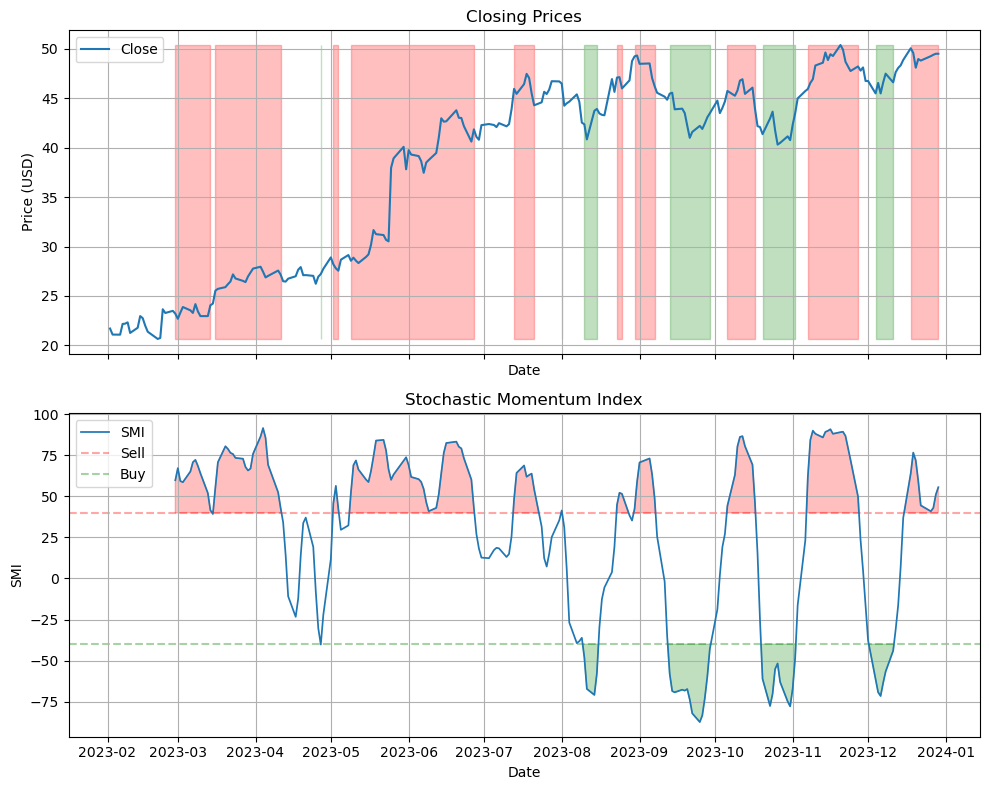

{'buy': DatetimeIndex(['2023-04-27 00:00:00-04:00', '2023-08-10 00:00:00-04:00',
                '2023-08-11 00:00:00-04:00', '2023-08-14 00:00:00-04:00',
                '2023-08-15 00:00:00-04:00', '2023-09-13 00:00:00-04:00',
                '2023-09-14 00:00:00-04:00', '2023-09-15 00:00:00-04:00',
                '2023-09-18 00:00:00-04:00', '2023-09-19 00:00:00-04:00',
                '2023-09-20 00:00:00-04:00', '2023-09-21 00:00:00-04:00',
                '2023-09-22 00:00:00-04:00', '2023-09-25 00:00:00-04:00',
                '2023-09-26 00:00:00-04:00', '2023-09-27 00:00:00-04:00',
                '2023-09-28 00:00:00-04:00', '2023-09-29 00:00:00-04:00',
                '2023-10-20 00:00:00-04:00', '2023-10-23 00:00:00-04:00',
                '2023-10-24 00:00:00-04:00', '2023-10-25 00:00:00-04:00',
                '2023-10-26 00:00:00-04:00', '2023-10-27 00:00:00-04:00',
                '2023-10-30 00:00:00-04:00', '2023-10-31 00:00:00-04:00',
                '2023-11-01 00:

In [226]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Fetch historical data for NVDA

def my_smi(ticker, start, end, interval, lookback=14, smooth_k=3, smooth_d=3, min_level=-40, max_level=40):
    time_series = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
    high_max = time_series['High'].rolling(window=lookback).max()
    low_min = time_series['Low'].rolling(window=lookback).min()
    
    mid_point = (high_max + low_min) / 2
    price_diff = time_series['Close'] - mid_point
    
    smi_numerator = price_diff.rolling(window=smooth_k).mean()
    smi_denominator = (high_max - low_min).rolling(window=smooth_k).mean()
    
    SMI = (smi_numerator / (smi_denominator / 2)) * 100
    SMI = SMI.rolling(window=smooth_d).mean().dropna()
    
    signals = {
        'buy': [],
        'sell': []
    }
    
    signals['buy'] = SMI[SMI < min_level].index
    signals['sell'] = SMI[SMI > max_level].index
    
    fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

    ax[0].plot(time_series.index, time_series['Close'], label='Close')
    ax[0].set_title('Closing Prices')
    ax[0].fill_between(SMI.index, time_series['Close'].min(), time_series['Close'].max(), where = (SMI > max_level), alpha=0.25, color ='r', interpolate=False)
    ax[0].fill_between(SMI.index, time_series['Close'].min(), time_series['Close'].max(), where = (SMI < min_level), alpha=0.25, color ='g', interpolate=False)
    ax[0].set_ylabel('Price (USD)')
    
    ax[1].plot(SMI.index, SMI, label='SMI', linewidth=1.25)
    ax[1].set_title('Stochastic Momentum Index')
    ax[1].set_ylabel('SMI')
    ax[1].fill_between(SMI.index, SMI, max_level, where = (SMI > max_level), alpha=0.25, color ='r', interpolate=True)
    ax[1].fill_between(SMI.index, SMI, min_level, where = (SMI < min_level), alpha=0.25, color ='g', interpolate=True)
    ax[1].axhline(y=max_level, color='r', zorder=-3, alpha=0.35, linestyle='--', label='Sell')
    ax[1].axhline(y=min_level, color='g', zorder=-3, alpha=0.35, linestyle='--', label='Buy')
    
    for i, series in enumerate(['Close', 'SMI']):

        ax[i].set_xlabel('Date')
        ax[i].grid()
        ax[i].legend()
    plt.tight_layout()
    plt.show()
    
    return signals


my_smi('NVDA', '2023-02-02', '2024-01-01', '1d', lookback=14, smooth_k=3, smooth_d=3, min_level=-40, max_level=40)

## Bollinger Bands

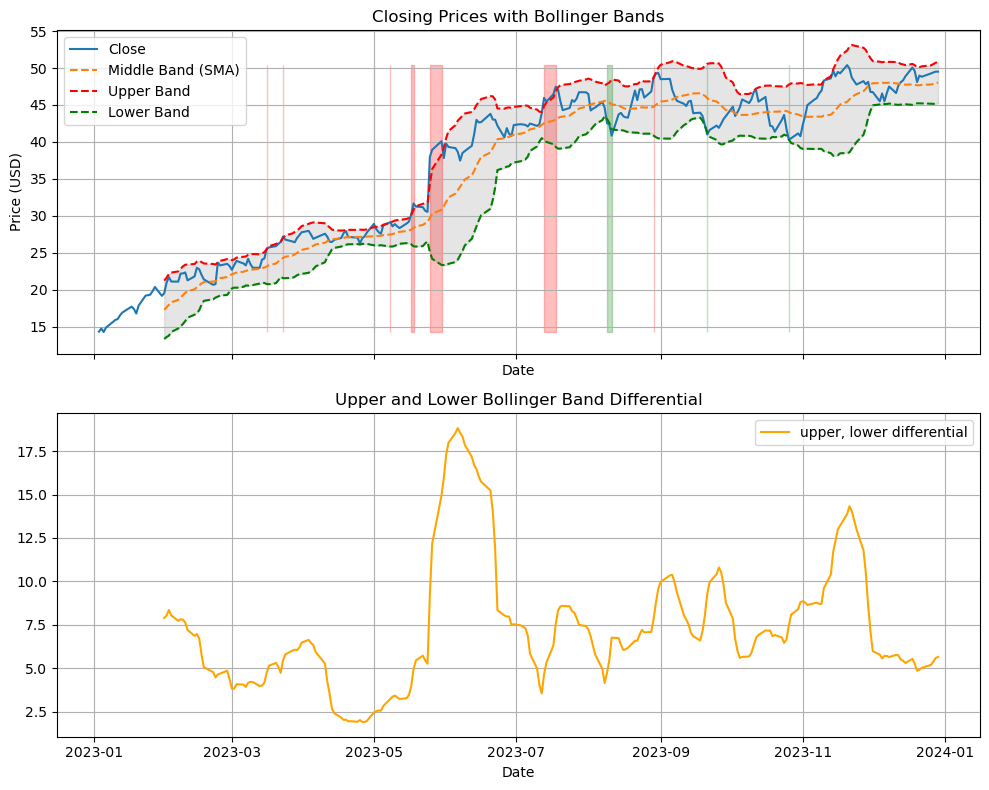

In [233]:
import yfinance as yf
import matplotlib.pyplot as plt

def my_bollinger_bands(ticker, start, end, interval, lookback=20, num_std_dev=2):
    # Fetch historical data
    time_series = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
    
    # Calculate the Moving Average (Middle Band)
    middle_band = time_series['Close'].rolling(window=lookback).mean()
    
    # Calculate the Standard Deviation
    std_dev = time_series['Close'].rolling(window=lookback).std()
    
    # Calculate the Upper and Lower Bands
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)
    
    # Generate Buy/Sell signals
    signals = {
        'buy': [],
        'sell': []
    }

    signals['buy'] = time_series[time_series['Close'] < lower_band].index
    signals['sell'] = time_series[time_series['Close'] > upper_band].index
    
    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax[0].plot(time_series.index, time_series['Close'], label='Close')
    ax[0].plot(time_series.index, middle_band, label='Middle Band (SMA)', linestyle='--')
    ax[0].plot(time_series.index, upper_band, label='Upper Band', linestyle='--', color='r')
    ax[0].plot(time_series.index, lower_band, label='Lower Band', linestyle='--', color='g')
    ax[0].fill_between(time_series.index, lower_band, upper_band, color='grey', alpha=0.2)
    ax[0].set_title('Closing Prices with Bollinger Bands')
    ax[0].set_ylabel('Price (USD)')

    # Highlight Buy/Sell areas
    ax[0].fill_between(time_series.index, time_series['Close'].min(), time_series['Close'].max(), 
                       where=(time_series['Close'] < lower_band), alpha=0.25, color='g', interpolate=False)
    ax[0].fill_between(time_series.index, time_series['Close'].min(), time_series['Close'].max(), 
                       where=(time_series['Close'] > upper_band), alpha=0.25, color='r', interpolate=False)

    # Plot the Bollinger Bands indicator
    ax[1].plot(time_series.index, upper_band-lower_band, label='upper, lower differential', color='orange')
    ax[1].set_title('Upper and Lower Bollinger Band Differential')
    
    
    for i in range(2):
        ax[i].set_xlabel('Date')
        ax[i].grid()
        ax[i].legend()
    
    plt.tight_layout()
    plt.show()

    return signals

# Example usage
signals = my_bollinger_bands('NVDA', '2023-01-01', '2024-01-01', '1d', 20, 2)


## ARIMA

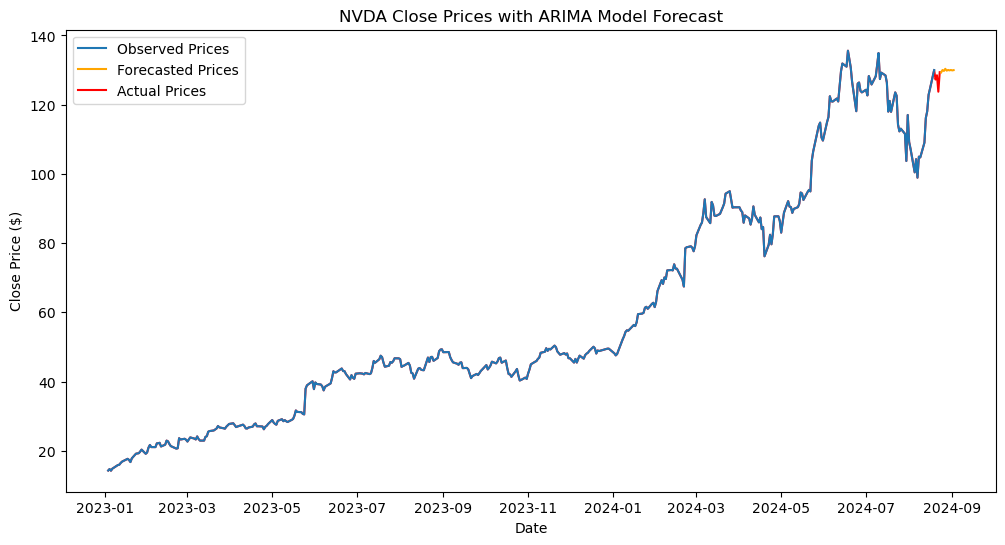

In [30]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

my_time_series_data = yf.Ticker('NVDA').history(start='2023-01-01', end='2024-08-20', interval='1d')
my_time_series_data = pd.DataFrame(my_time_series_data)

close_prices = my_time_series_data['Close']

# Build and fit the ARIMA model (using p=5, d=1, q=0 as an example)
model = ARIMA(close_prices, order=(5, 1, 0))
model_fit = model.fit()

# Forecast the next 10 steps
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Get the dates for the forecasted period
forecast_dates = pd.date_range(start=close_prices.index[-1] + pd.Timedelta(days=5), periods=forecast_steps, freq='1D')

# Fetch actual data for comparison
test_ = yf.Ticker('NVDA').history(start='2023-01-01', end='2024-08-30', interval='1d')

# Plot the original data, forecasted values, and actual prices
plt.figure(figsize=(12, 6))
plt.plot(close_prices, label='Observed Prices')
plt.plot(forecast_dates, forecast, label='Forecasted Prices', color='orange')
plt.plot(test_.index, test_['Close'], label='Actual Prices', color='red', zorder = -1)
plt.title('NVDA Close Prices with ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()
